In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import parallel_backend
import numpy as np
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
import os
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv

from tqdm  import tqdm

os.getcwd()

'/workspaces/muldistribution/EDA'

# データ読み込みと前処理
この処理で、それぞれいろんな形式を持つデータを統合。全国各1kmグリッドに対して診療科別POI件数、人口、セントロイド座標を付与し、geopackageとcsvで出力している。(geopackageいるかな？)

In [ ]:
"""
全国 1 km グリッドに
  ① 診療科別 POI 件数
  ② 人口
  ③ セントロイド座標（メートル系）
を付与し、GeoPackage と CSV を出力するユーティリティ。
"""

from pathlib import Path
import geopandas as gpd

# ───────── 0. パス定義 ────────────────────────────────
DATA_DIR   = Path("../data")
GRID_PATH  = DATA_DIR / "grid/wholejapan_grid/wholejapan_grid.shp"
POP_PATH   = DATA_DIR / "pop/2010/pop_grid.gpkg"
POI_DIR    = DATA_DIR / "medicalpoi/2010"

OUTPUT_GPKG = Path("grid_features.gpkg")
OUTPUT_CSV  = Path("grid_features.csv")

POI_FILES = {
    "Rehab" : POI_DIR / "リハビリテーション科.shp",
    "Gastro": POI_DIR / "消化器内科.shp",
    "Cardio": POI_DIR / "循環器内科.shp",
    "Uro"   : POI_DIR / "泌尿器内科.shp",
}

POP_COL   = "Total population"   # pop_grid.gpkg 内の列名
GRID_ID   = "grid_id"            # 無ければ自動生成
TARGET_EPSG = 6697               # JGD2011 / Albers（メートル系）

# ───────── 1. ヘルパー関数群 ─────────────────────────
def read_layer(path: Path, crs_like) -> gpd.GeoDataFrame:
    """CRS を揃えて読み込む（Undefined → crs_like をセット）"""
    gdf = gpd.read_file(path)
    if gdf.crs is None:
        gdf = gdf.set_crs(crs_like)
    return gdf.to_crs(crs_like)

def attach_poi_counts(grid: gpd.GeoDataFrame,
                      poi_path: Path,
                      out_col: str) -> gpd.GeoDataFrame:
    """POI シェープを読み込み、グリッド内件数を付与"""
    poi   = read_layer(poi_path, grid.crs)
    cnt   = (
        gpd.sjoin(poi[['geometry']], grid[[GRID_ID, 'geometry']],
                  predicate='within', how='left')
        .groupby(GRID_ID).size().rename(out_col)
    )
    grid  = grid.join(cnt, on=GRID_ID)
    grid[out_col] = grid[out_col].fillna(0).astype('uint16')
    return grid

# ───────── 2. グリッド GDF 準備 ──────────────────────
grid = read_layer(GRID_PATH, 4326)
if GRID_ID not in grid.columns:
    grid[GRID_ID] = grid.index.astype(int)

# ───────── 3. 診療科 POI 件数の付与 ──────────────────
for short, shp in POI_FILES.items():
    grid = attach_poi_counts(grid, shp, f"{short}_cnt")

# ───────── 4. 人口メッシュ集計（intersects 合計） ─────
pop = read_layer(POP_PATH, grid.crs)[[POP_COL, 'geometry']]
pop_sum = (
    gpd.sjoin(pop, grid[[GRID_ID, 'geometry']],
              predicate='intersects', how='left')
    .groupby(GRID_ID)[POP_COL].sum()
    .rename("population")
)
grid = grid.join(pop_sum, on=GRID_ID)
grid["population"] = grid["population"].fillna(0).astype('uint32')

# ───────── 5. セントロイド XY（メートル系） ──────────
grid_proj = grid.to_crs(TARGET_EPSG)
cent = grid_proj.geometry.centroid 
grid["centroid_X"] = cent.x
grid["centroid_Y"] = cent.y

# ───────── 6. 出力 ────────────────────────────────
grid.to_file(OUTPUT_GPKG, layer="features", driver="GPKG", overwrite=True)
grid.drop(columns='geometry').to_csv(OUTPUT_CSV, index=False)

print("✅ Saved:", OUTPUT_GPKG, "and", OUTPUT_CSV)

In [2]:
grid = pd.read_csv("grid_features.csv")
grid.head()

,KEY_CODE,MESH1_ID,MESH2_ID,MESH3_ID,OBJ_ID,grid_id,Rehab_cnt,Gastro_cnt,Cardio_cnt,Uro_cnt,population,centroid_X,centroid_Y
0,66440000,6644.0,0.0,0.0,1.0,0,0,0,0,0,4,144.00625,44.004167
1,66440001,6644.0,0.0,1.0,2.0,1,0,0,0,0,0,144.01875,44.004167
2,66440002,6644.0,0.0,2.0,3.0,2,0,0,0,0,0,144.03125,44.004167
3,66440003,6644.0,0.0,3.0,4.0,3,0,0,0,0,0,144.04375,44.004167
4,66440004,6644.0,0.0,4.0,5.0,4,0,0,0,0,0,144.05625,44.004167


# 各診療科の相関だけみとく。

In [3]:
cols = ["Rehab_cnt", "Gastro_cnt", "Cardio_cnt", "Uro_cnt"]
corr = grid[cols].corr(method="spearman")   # カウントは歪みが大きいので rank 相関が無難
print(corr.round(3))

            Rehab_cnt  Gastro_cnt  Cardio_cnt  Uro_cnt
Rehab_cnt       1.000       0.638       0.600    0.501
Gastro_cnt      0.638       1.000       0.705    0.484
Cardio_cnt      0.600       0.705       1.000    0.491
Uro_cnt         0.501       0.484       0.491    1.000


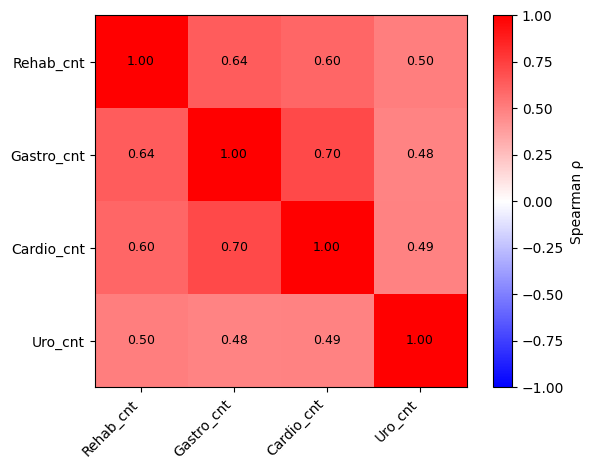

In [4]:
fig, ax = plt.subplots()

im = ax.imshow(corr, vmin=-1, vmax=1, cmap="bwr")

# 軸ラベル
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha="right")
ax.set_yticklabels(cols)

# 値を描き込む
for i in range(len(cols)):
    for j in range(len(cols)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center", color="black", fontsize=9)

fig.colorbar(im, ax=ax, label="Spearman ρ")
plt.tight_layout()
plt.show()

→結構相関高いね、まとめてモデル回したほうがいいんじゃない？

# random forest の構築

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  HalvingGridSearchCV で省メモリ&高速にランダムフォレストを最適化  ║
# ╚══════════════════════════════════════════════════════════════════════╝

# ── 必要ライブラリ ──────────────────────────────────────────────
import numpy as np
import pandas as pd
from joblib import parallel_backend
from tqdm import tqdm

from sklearn.experimental import enable_halving_search_cv  # ★必須：一行で有効化
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# ── 0. 入力 DataFrame ──────────────────────────────────────────
df = grid.copy()
# --------------------------------------------------------------
# df = ...

# ── 1. 共通設定 ────────────────────────────────────────────────
FEATURES = ["population", "centroid_X", "centroid_Y"]

TARGETS = {                       # {列名: 表示ラベル}
    "Rehab_cnt":  "Rehabilitation",
    "Gastro_cnt": "Gastroenterology",
    "Cardio_cnt": "Cardiology",
    "Uro_cnt":    "Urology (Med.)"
}

TEST_SIZE     = 0.20
CV_FOLDS      = 5
SEED          = 42
N_JOBS        = 4                 # 物理コア数の半分程度に抑えると安定

# RMSE を返す scorer (GridSearch は “大きいほど良い” が前提なので符号を反転)
rmse_scorer = make_scorer(
    lambda y, yhat: np.sqrt(mean_squared_error(y, yhat)),
    greater_is_better=False
)

# ── 2. ハイパーパラメータグリッド  (メモリに優しいサブセット) ─────────
param_grid = {
    "n_estimators":      [100, 300],          # ← より軽量
    "max_depth":         [None, 20, 40],
    "min_samples_split": [2, 5],
    "min_samples_leaf":  [1, 2],
    "max_features":      ["sqrt", 0.7]        # 0.7 = 全特徴量の 70 %
}

print(f"Grid size: {np.prod([len(v) for v in param_grid.values()])} × {CV_FOLDS}-fold CV")

# ── 3. 診療科ごとに学習 ───────────────────────────────────────
for col, label in tqdm(TARGETS.items()):
    print(f"\n🏥  {label} ({col}) — training...")

    X = df[FEATURES].fillna(0)
    y = df[col].fillna(0)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=SEED
    )

    base_rf = RandomForestRegressor(
        n_jobs=N_JOBS,
        random_state=SEED
    )

    gsearch = HalvingGridSearchCV(
        base_rf,
        param_grid=param_grid,
        factor=3,                    # 生き残り比率 1/3
        scoring=rmse_scorer,
        refit=True,                  # ベスト RMSE で再学習済み
        cv=CV_FOLDS,
        n_jobs=N_JOBS,
        verbose=0
    )

    # ★必要に応じて "threading" にすると更にメモリ節約
    with parallel_backend("loky"):
        gsearch.fit(X_tr, y_tr)

    best = gsearch.best_estimator_
    y_pred = best.predict(X_te)

    rmse_test = np.sqrt(mean_squared_error(y_te, y_pred))
    r2_test   = r2_score(y_te, y_pred)

    print(f"   RMSE_test = {rmse_test:7.3f}   R²_test = {r2_test:6.3f}")
    print("   best_params :", gsearch.best_params_)

Grid size: 48 × 5-fold CV


  0%|          | 0/4 [00:00<?, ?it/s]


🏥  Rehabilitation (Rehab_cnt) — training...


 25%|██▌       | 1/4 [04:55<14:47, 295.70s/it]

   RMSE_test =   0.658   R²_test =  0.443
   best_params : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

🏥  Gastroenterology (Gastro_cnt) — training...


 50%|█████     | 2/4 [10:12<10:15, 307.84s/it]

   RMSE_test =   0.603   R²_test =  0.495
   best_params : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

🏥  Cardiology (Cardio_cnt) — training...


 75%|███████▌  | 3/4 [14:53<04:55, 295.77s/it]

   RMSE_test =   0.435   R²_test =  0.416
   best_params : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

🏥  Urology (Med.) (Uro_cnt) — training...


100%|██████████| 4/4 [18:52<00:00, 283.18s/it]

   RMSE_test =   0.553   R²_test =  0.245
   best_params : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


Exception ignored in: <function ResourceTracker.__del__ at 0xffff8423bf60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0xffff7b933f60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0xffff897c7f60>
Traceback (most recent call last):
  File "/usr

In [11]:
# ── 4. モデルを pkl で保存 ────────────────────────────────
import os, joblib

SAVE_DIR = "models"            # ディレクトリ名はお好みで
os.makedirs(SAVE_DIR, exist_ok=True)

# いま回した gsearch / best をもう一度走査して保存
for col, label in TARGETS.items():
    filename = f"{SAVE_DIR}/{col}_rf.pkl"     # 例: models/Rehab_cnt_rf.pkl
    joblib.dump(
        gsearch.best_estimator_ if label in locals() else None, 
        filename
    )
    print(f"📦 Saved →  {filename}")

📦 Saved →  models/Rehab_cnt_rf.pkl
📦 Saved →  models/Gastro_cnt_rf.pkl
📦 Saved →  models/Cardio_cnt_rf.pkl
📦 Saved →  models/Uro_cnt_rf.pkl


# XGBoostベースラインの構築

In [12]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║      HalvingGridSearchCV × XGBoostRegressor（省メモリ & 高速）     ║
# ╚══════════════════════════════════════════════════════════════════════╝
# ❶ もし「No module named 'xgboost'」が出たら:
#     pip install -q xgboost==2.0.3
#    （scikit-learn API が安定している 2 系を推奨）
# ────────────────────────────────────────────────────────────────────────

import numpy as np, pandas as pd, os
from tqdm import tqdm
from joblib import parallel_backend

from sklearn.experimental import enable_halving_search_cv      # noqa
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

from xgboost import XGBRegressor

# ── 0. DataFrame ───────────────────────────────────────────────────────
df = grid.copy()                    # 例: 既存の grid データ
FEATURES = ["population", "centroid_X", "centroid_Y"]

TARGETS = {
    "Rehab_cnt":  "Rehabilitation",
    "Gastro_cnt": "Gastroenterology",
    "Cardio_cnt": "Cardiology",
    "Uro_cnt":    "Urology (Med.)"
}

# ── 1. 共通ハイパーパラメータ ─────────────────────────────────
TEST_SIZE, CV_FOLDS, SEED, N_JOBS = 0.20, 5, 42, 4

rmse_scorer = make_scorer(
    lambda y, yhat: np.sqrt(mean_squared_error(y, yhat)),
    greater_is_better=False
)

# XGBoost 用グリッド（軽め）
param_grid = {
    "n_estimators":      [200, 400],
    "max_depth":         [3, 6, 10],
    "learning_rate":     [0.05, 0.1],
    "subsample":         [0.8, 1.0],
    "colsample_bytree":  [0.8, 1.0],
    "reg_lambda":        [1.0, 5.0]
}
print(f"Grid size: {np.prod([len(v) for v in param_grid.values()])} × {CV_FOLDS}-fold CV")

# ── 2. 学習ループ ──────────────────────────────────────────────
for col, label in tqdm(TARGETS.items()):
    print(f"\n🏥  {label} ({col}) — training...")

    X = df[FEATURES].fillna(0)
    y = df[col].fillna(0)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=SEED
    )

    base_xgb = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",      # CPU最速
        n_jobs=N_JOBS,
        random_state=SEED,
        verbosity=0
    )

    gsearch = HalvingGridSearchCV(
        base_xgb,
        param_grid=param_grid,
        factor=3,
        scoring=rmse_scorer,
        refit=True,
        cv=CV_FOLDS,
        n_jobs=N_JOBS,
        verbose=0
    )

    # メモリ節約したい場合は "threading"
    with parallel_backend("loky"):
        gsearch.fit(X_tr, y_tr)

    best = gsearch.best_estimator_
    y_pred = best.predict(X_te)

    rmse_test = np.sqrt(mean_squared_error(y_te, y_pred))
    r2_test   = r2_score(y_te, y_pred)

    print(f"   RMSE_test = {rmse_test:7.3f}   R²_test = {r2_test:6.3f}")
    print("   best_params :", gsearch.best_params_)

    # ─ 保存 (pkl) ────────────────────────────────────────────
    os.makedirs("models_xgb", exist_ok=True)
    best.save_model(f"models_xgb/{col}_xgb.json")   # XGBoost ネイティブ形式
    print(f"📦  saved → models_xgb/{col}_xgb.json")

Grid size: 96 × 5-fold CV


  0%|          | 0/4 [00:00<?, ?it/s]


🏥  Rehabilitation (Rehab_cnt) — training...


 25%|██▌       | 1/4 [00:35<01:45, 35.26s/it]

   RMSE_test =   0.662   R²_test =  0.437
   best_params : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 5.0, 'subsample': 0.8}
📦  saved → models_xgb/Rehab_cnt_xgb.json

🏥  Gastroenterology (Gastro_cnt) — training...


 50%|█████     | 2/4 [01:07<01:07, 33.60s/it]

   RMSE_test =   0.624   R²_test =  0.460
   best_params : {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 5.0, 'subsample': 0.8}
📦  saved → models_xgb/Gastro_cnt_xgb.json

🏥  Cardiology (Cardio_cnt) — training...


 75%|███████▌  | 3/4 [01:39<00:32, 32.92s/it]

   RMSE_test =   0.443   R²_test =  0.394
   best_params : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'reg_lambda': 5.0, 'subsample': 1.0}
📦  saved → models_xgb/Cardio_cnt_xgb.json

🏥  Urology (Med.) (Uro_cnt) — training...


100%|██████████| 4/4 [02:08<00:00, 32.16s/it]

   RMSE_test =   0.554   R²_test =  0.241
   best_params : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 5.0, 'subsample': 0.8}
📦  saved → models_xgb/Uro_cnt_xgb.json


# LightGBMベースラインの構築

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║        HalvingGridSearchCV × LightGBMRegressor  (省メモリ高速)       ║
# ╚══════════════════════════════════════════════════════════════════════╝
# LightGBM でも 3 特徴量で問題なく動きます。n_jobs を絞り
# tree_method などの指定は不要です。

import numpy as np, pandas as pd, os, warnings, lightgbm as lgb, logging
from tqdm import tqdm
from joblib import parallel_backend

from sklearn.experimental import enable_halving_search_cv   # noqa
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


logging.getLogger("lightgbm").setLevel(logging.CRITICAL)   # Info を黙らせる
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

# ── 0. DataFrame ───────────────────────────────────────────
df = grid.copy()                     # 例: 既にある DataFrame
FEATURES = ["population", "centroid_X", "centroid_Y"]

TARGETS = {
    "Rehab_cnt":  "Rehabilitation",
    "Gastro_cnt": "Gastroenterology",
    "Cardio_cnt": "Cardiology",
    "Uro_cnt":    "Urology (Med.)"
}

# ── 1. 共通パラメータ ───────────────────────────────
TEST_SIZE, CV_FOLDS, SEED, N_JOBS = 0.20, 5, 42, 4

rmse_scorer = make_scorer(
    lambda y, yhat: np.sqrt(mean_squared_error(y, yhat)),
    greater_is_better=False
)

# ── 2. ハイパーパラメータグリッド ───────────────────
param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [15, 31],
    "max_depth": [3, 6],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}
import math
print(f"Grid size: {math.prod([len(v) for v in param_grid.values()])} × {CV_FOLDS}-fold CV")

# ── 3. 科目ごと学習 ───────────────────────────────────
for col, label in tqdm(TARGETS.items()):
    print(f"\n🏥  {label} ({col}) — training...")

    X = df[FEATURES].fillna(0)
    y = df[col].fillna(0)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=SEED
    )

    base_lgb = lgb.LGBMRegressor(
        objective="regression",
        n_jobs=N_JOBS,
        random_state=SEED,
        verbosity=-1,
        force_row_wise=True 
    )

    gsearch = HalvingGridSearchCV(
        base_lgb,
        param_grid=param_grid,
        factor=3,                 # 上位 1/3 で次ラウンド
        scoring=rmse_scorer,
        refit=True,
        cv=CV_FOLDS,
        n_jobs=N_JOBS,
        verbose=0
    )

    # 省メモリ化：必要なら "threading" へ
    with parallel_backend("loky"):
        gsearch.fit(X_tr, y_tr)

    best = gsearch.best_estimator_
    y_pred = best.predict(X_te)

    rmse_test = np.sqrt(mean_squared_error(y_te, y_pred))
    r2_test   = r2_score(y_te, y_pred)

    print(f"   RMSE_test = {rmse_test:7.3f}   R²_test = {r2_test:6.3f}")
    print("   best_params :", gsearch.best_params_)

    # ── モデル保存 (LightGBM ネイティブ) ───────────────────
    os.makedirs("models_lgb", exist_ok=True)
    best.booster_.save_model(f"models_lgb/{col}_lgb.txt")
    print(f"📦  saved → models_lgb/{col}_lgb.txt")

Grid size: 64 × 5-fold CV


  0%|          | 0/4 [00:00<?, ?it/s]


🏥  Rehabilitation (Rehab_cnt) — training...


 25%|██▌       | 1/4 [05:23<16:11, 323.77s/it]

   RMSE_test =   0.657   R²_test =  0.445
   best_params : {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 15, 'subsample': 1.0}
📦  saved → models_lgb/Rehab_cnt_lgb.txt

🏥  Gastroenterology (Gastro_cnt) — training...
